In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
import pandas as pd 
import seaborn as sns
from shapely import wkt
from shapely.geometry import Point

sns.set_theme()

In [39]:
slow_streets = gpd.read_file("/Users/katherinementzer/Downloads/Slow_Streets.csv", crs='epsg:4326')
slow_streets['geometry'] = slow_streets['shape'].apply(wkt.loads)
slow_streets = slow_streets.set_crs('epsg:4326')
slow_streets = slow_streets.to_crs('epsg:3857')

In [40]:
path = os.path.expanduser('~/SFUSD/Census 2010_ Blocks for San Francisco/geo_export_d4e9e90c-ff77-4dc9-a766-6a1a7f7d9f9c.shp')
census = gpd.read_file(path)
census['geoid10'] = census['geoid10'].fillna(value=0).astype('int64', copy=False)
df = pd.read_csv('~/Dropbox/SFUSD/Optimization/block_blockgroup_tract.csv')
df['Block'] = df['Block'].fillna(value=0).astype('int64', copy=False)
census = census.merge(df,how='left',left_on='geoid10',right_on='Block')
census = census.dissolve(by="BlockGroup", as_index=False)
census = census.to_crs('epsg:3857')

In [41]:
cleanschoolpath = '/Users/katherinementzer/Dropbox/SFUSD/Data/Cleaned/schools_table_for_zone_development.csv'
sc_df = pd.read_csv(cleanschoolpath)
geometry = [Point(xy) for xy in zip(sc_df['lon'], sc_df['lat'])]
sc_df = gpd.GeoDataFrame(sc_df, crs='epsg:4326', geometry=geometry)
sc_df = sc_df.to_crs('epsg:3857')

<AxesSubplot:>

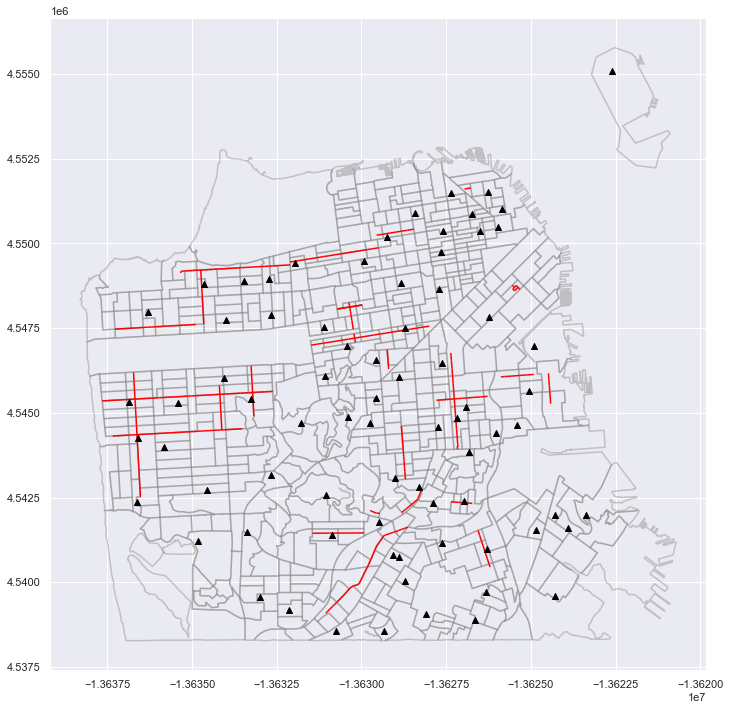

In [42]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
sc_df.plot(ax=ax, c='black', marker='^', zorder=50)
slow_streets.plot(ax=ax, color='red')

In [43]:
buffered_sch = sc_df.copy()
buffered_sch['geometry'] = buffered_sch['geometry'].buffer(402)

In [44]:
relevant_schools = gpd.sjoin(buffered_sch, slow_streets, how='inner')
relevant_schools = relevant_schools.groupby('school_id',as_index=False).first()[['school_id','lat','lon','geometry']]

In [45]:
streets = slow_streets.dissolve(by='streetname')
relevant_streets = gpd.sjoin(streets, buffered_sch).drop(columns=['index_right'])

In [46]:
def get_relevant_streets(streets, buffered_sch, school_id):
    school = buffered_sch.loc[buffered_sch.school_id == school_id]
    return gpd.sjoin(streets, school).drop(columns=['index_right'])

In [47]:
buffered_census = census.copy()
buffered_census.geometry = census.centroid.buffer(402)#.rename(columns={'BlockGroup_left': 'BlockGroup'})
buffered_census['block_lat'] = buffered_census.to_crs('epsg:4326').centroid.y
buffered_census['block_lon'] = buffered_census.to_crs('epsg:4326').centroid.x
relevant_blocks = gpd.sjoin(buffered_census, relevant_streets)

/var/folders/sm/3fwnfv0s4dz92rkrtnq8vcbr0000gn/T/ipykernel_18754/1296274912.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_census['block_lat'] = buffered_census.to_crs('epsg:4326').centroid.y
/var/folders/sm/3fwnfv0s4dz92rkrtnq8vcbr0000gn/T/ipykernel_18754/1296274912.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_census['block_lon'] = buffered_census.to_crs('epsg:4326').centroid.x


In [48]:
def get_relevant_blocks(streets, buffered_sch, buffered_census, school_id):
    relevant_streets = get_relevant_streets(streets, buffered_sch, school_id)
    return gpd.sjoin(buffered_census, relevant_streets).rename(columns={'BlockGroup_left': 'BlockGroup'})

get_relevant_blocks(streets, buffered_sch, buffered_census, 413)

BlockGroup                                           geometry  aland10  \
507  6.075043e+10  POLYGON ((-13634182.207 4548642.511, -13634184...  19607.0   
508  6.075043e+10  POLYGON ((-13634106.462 4548999.286, -13634108...  19443.0   
512  6.075043e+10  POLYGON ((-13634626.605 4548937.315, -13634628...  19595.0   
530  6.075048e+10  POLYGON ((-13634647.532 4548268.245, -13634649...  19623.0   
531  6.075048e+10  POLYGON ((-13634103.997 4548167.877, -13634105...   1346.0   
532  6.075048e+10  POLYGON ((-13634632.367 4547997.183, -13634634...  19514.0   
533  6.075048e+10  POLYGON ((-13634617.287 4547734.576, -13634619...  19496.0   
534  6.075048e+10  POLYGON ((-13634073.563 4547634.108, -13634075...  19608.0   
535  6.075048e+10  POLYGON ((-13634602.258 4547471.741, -13634604...  19600.0   

     awater10 blockce10 countyfp10 funcstat10         geoid10   intptlat10  \
507       0.0      1003        075          S  60750426011003  +37.7812015   
508       0.0      2002        075          S  60750426012002  +37.7849812   
512       0.0      1000        075          S  60750427001000  +37.7848375   
530       0.0      1004        075          S  60750477011004  +37.7790733   
531       0.0      2000        075          S  60750477012000  +37.7803093   
532       0.0      3004        075          S  60750477013004  +37.7771121   
533       0.0      1004        075          S  60750477021004  +37.7752471   
534       0.0      2003        075          S  60750477022003  +37.7736251   
535       0.0      3002        075          S  60750477023002  +37.7734789   

       intptlon10  ... ela_color math_color chronic_color suspension_color  \
507  -122.4821278  ...     Green      Green        Orange             Blue   
508  -122.4813262  ...     Green      Green        Orange             Blue   
512  -122.4845437  ...     Green      Green        Orange             Blue   
530  -122.4851982  ...     Green      Green        Orange             Blue   
531  -122.4799111  ...     Green      Green        Orange             Blue   
532  -122.4872038  ...     Green      Green        Orange             Blue   
533  -122.4870688  ...     Green      Green        Orange             Blue   
534  -122.4815813  ...     Green      Green        Orange             Blue   
535  -122.4847948  ...     Green      Green        Orange             Blue   

    attendance_area   Block_right  BlockGroup_right  Tract_right  \
507             413  6.075040e+13       60750426011   6075042601   
508             413  6.075040e+13       60750426011   6075042601   
512             413  6.075040e+13       60750426011   6075042601   
530             413  6.075040e+13       60750426011   6075042601   
531             413  6.075040e+13       60750426011   6075042601   
532             413  6.075040e+13       60750426011   6075042601   
533             413  6.075040e+13       60750426011   6075042601   
534             413  6.075040e+13       60750426011   6075042601   
535             413  6.075040e+13       60750426011   6075042601   

     MetStandards  AvgColorIndex  
507      0.614786           3.75  
508      0.614786           3.75  
512      0.614786           3.75  
530      0.614786           3.75  
531      0.614786           3.75  
532      0.614786           3.75  
533      0.614786           3.75  
534      0.614786           3.75  
535      0.614786           3.75  

[9 rows x 62 columns]

<AxesSubplot:>

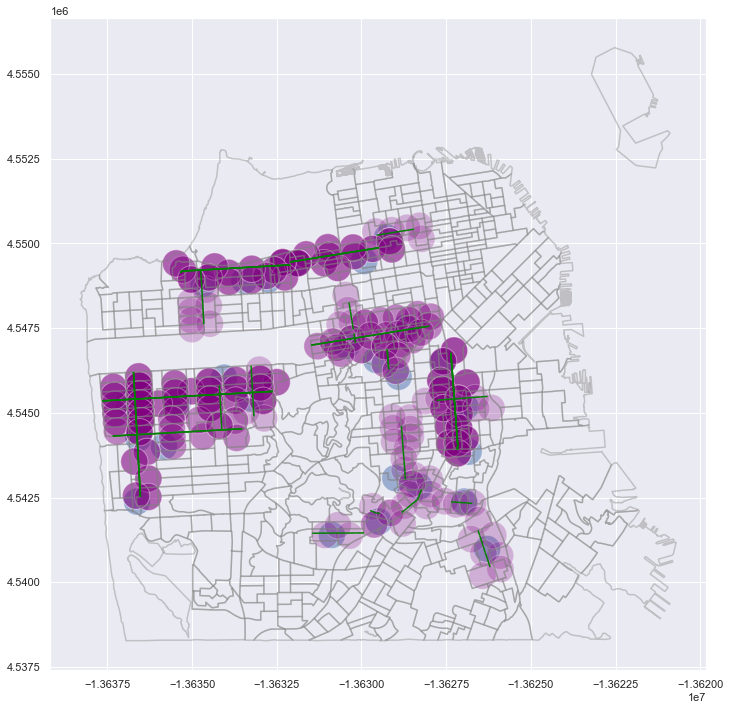

In [49]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
relevant_schools.plot(ax=ax, alpha=.5)
# slow_streets.plot(ax=ax, color='red')
relevant_streets.plot(ax=ax, color='green')
relevant_blocks.plot(ax=ax, color='purple', alpha=.25)

In [64]:
buffered = slow_streets.copy()
buffered.geometry = buffered.geometry.buffer(402)
slow_street_poly = buffered.dissolve()

<AxesSubplot:>

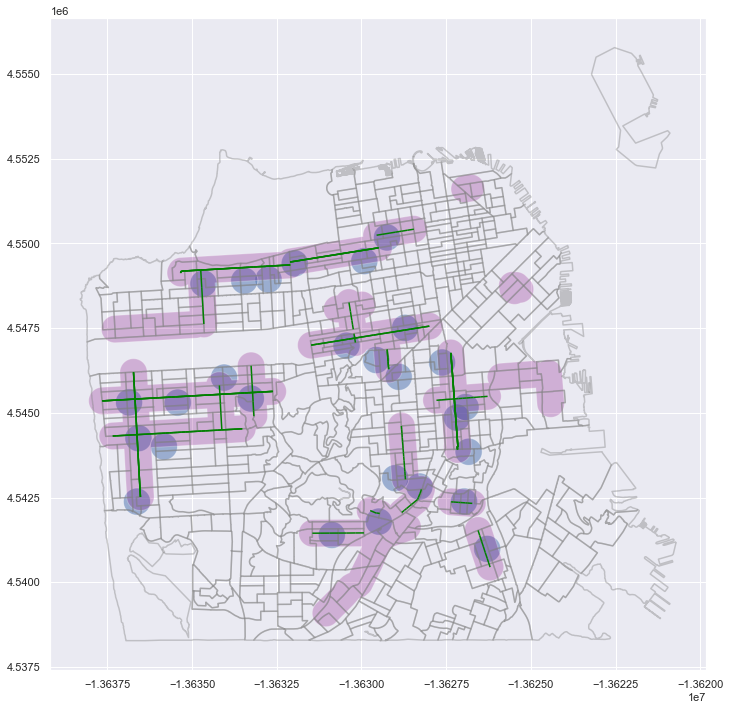

In [65]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
relevant_schools.plot(ax=ax, alpha=.5)
# slow_streets.plot(ax=ax, color='red')
relevant_streets.plot(ax=ax, color='green')
slow_street_poly.plot(ax=ax, color='purple', alpha=.25)

2022-02-18 12:08:49 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-02-18 12:08:49 Projected GeoDataFrame to epsg:4326
2022-02-18 12:08:49 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-02-18 12:08:49 Projected GeoDataFrame to epsg:4326
2022-02-18 12:08:49 Requesting data within polygon from API in 1 request(s)


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


2022-02-18 12:08:50 Pausing 0 seconds before making HTTP POST request
2022-02-18 12:08:50 Post http://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cconstruction%7Ccorridor%7Celevator%7Cescalator%7Cfootway%7Cmotor%7Cplanned%7Cplatform%7Cproposed%7Craceway%7Csteps%22%5D%5B%22bicycle%22%21~%22no%22%5D%5B%22service%22%21~%22private%22%5D%28poly%3A%2737.706558+-122.449596+37.706561+-122.450151+37.706576+-122.450505+37.706622+-122.451056+37.706665+-122.451406+37.706753+-122.451949+37.706823+-122.452293+37.706953+-122.452823+37.707049+-122.453155+37.707220+-122.453667+37.707342+-122.453987+37.707551+-122.454475+37.707697+-122.454778+37.732054+-122.503937+37.732209+-122.504233+37.732469+-122.504682+37.732645+-122.504957+37.732939+-122.505373+37.733136+-122.505625+37.733462+-122.506002+37.733677+-122.506229+37.734031+-122.506565+37.734263+-122.

/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


2022-02-18 12:09:04 Identified 46420 geometries inside polygon
2022-02-18 12:09:05 Removed 28683 nodes outside polygon
2022-02-18 12:09:05 Truncated graph by polygon
2022-02-18 12:09:05 Begin topologically simplifying the graph...
2022-02-18 12:09:06 Identified 11264 edge endpoints
2022-02-18 12:09:09 Simplified graph: 46420 to 11264 nodes, 87208 to 28266 edges
2022-02-18 12:09:09 Identifying all nodes that lie outside the polygon...
2022-02-18 12:09:10 Created nodes GeoDataFrame from graph
2022-02-18 12:09:10 Created r-tree spatial index for 11264 geometries


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


2022-02-18 12:09:10 Identified 4057 geometries inside polygon
2022-02-18 12:09:10 Removed 7207 nodes outside polygon
2022-02-18 12:09:10 Removed 37 isolated nodes
2022-02-18 12:09:10 Got largest weakly connected component (799 of 4020 total nodes)
2022-02-18 12:09:11 Truncated graph by polygon
2022-02-18 12:09:11 Counted undirected street segments incident to each node
2022-02-18 12:09:11 graph_from_polygon returned graph with 799 nodes and 2060 edges
2022-02-18 12:09:11 Begin plotting the graph...
2022-02-18 12:09:11 Created edges GeoDataFrame from graph
2022-02-18 12:09:11 Created nodes GeoDataFrame from graph


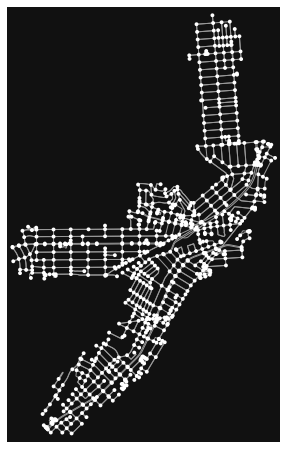

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

2022-02-18 12:09:11 Finished plotting the graph


In [66]:
g = ox.graph_from_polygon(polygon=buffered.dissolve().to_crs('epsg:4326').geometry[0], network_type = 'bike')
ox.plot_graph(g)

In [71]:
nx.number_strongly_connected_components(g)

5

In [73]:
for cc in nx.strongly_connected_components(g):
    print(cc)
#     ox.plot_graph(cc)

{1229920538, 1229920588}
{5443062646}
{297857223}
{2399950856, 9096921100, 9096921104, 6252544025, 65296411, 65296414, 665571358, 2078345247, 2078345250, 2078345251, 2078345252, 65296421, 65361957, 9090623527, 2078345253, 65314855, 65314857, 65306667, 65314859, 65294381, 65310768, 65294385, 65314864, 65310774, 65306680, 65361978, 65302586, 65333308, 65302588, 65306682, 65333311, 65306684, 315705409, 65333318, 65333320, 65294410, 65333322, 65333327, 65314903, 65333337, 65314914, 4216225894, 65314924, 65357939, 2449889397, 65314933, 65314940, 65357948, 65314953, 65355917, 65357968, 1712504981, 65337493, 65333397, 1712504984, 1711296665, 615405721, 65314988, 7150739631, 7150739632, 65327285, 65315003, 356718785, 3395381456, 297857235, 7148030176, 258973932, 1712505069, 2320396530, 356718835, 65306869, 1614176501, 65306872, 65343736, 65351930, 65306875, 65343740, 65343739, 65310974, 65351932, 65306880, 65310980, 3696021765, 65336188, 358887694, 3696021774, 1712505111, 65311003, 554160413, 

In [50]:
city_center = census.to_crs('epsg:4326').dissolve().centroid
(city_center[0].y, city_center[0].x)

/var/folders/sm/3fwnfv0s4dz92rkrtnq8vcbr0000gn/T/ipykernel_18754/3787035461.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  city_center = census.to_crs('epsg:4326').dissolve().centroid


(37.75617434158101, -122.44040063809926)

In [51]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

2022-02-18 12:01:29 Configured OSMnx 1.0.1
2022-02-18 12:01:29 HTTP response caching is on


In [52]:
G = ox.graph_from_point((city_center[0].y, city_center[0].x), dist=7800, network_type="walk" )

2022-02-18 12:01:29 Created bbox 7800 m from (37.75617434158101, -122.44040063809926): 37.826321327749454,37.68602735541256,-122.35167701966806,-122.52912425653047
2022-02-18 12:01:29 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-02-18 12:01:29 Projected GeoDataFrame to epsg:4326
2022-02-18 12:01:29 Projected GeoDataFrame to +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2022-02-18 12:01:29 Projected GeoDataFrame to epsg:4326
2022-02-18 12:01:29 Requesting data within polygon from API in 1 request(s)


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/osmnx/utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


2022-02-18 12:01:30 Pausing 0 seconds before making HTTP POST request
2022-02-18 12:01:30 Post http://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cconstruction%7Ccycleway%7Cmotor%7Cplanned%7Cplatform%7Cproposed%7Craceway%22%5D%5B%22foot%22%21~%22no%22%5D%5B%22service%22%21~%22private%22%5D%28poly%3A%2737.686027+-122.534795+37.826321+-122.534806+37.826763+-122.534778+37.827200+-122.534697+37.827629+-122.534561+37.828045+-122.534374+37.828444+-122.534136+37.828824+-122.533849+37.829179+-122.533518+37.829506+-122.533144+37.829803+-122.532731+37.830067+-122.532284+37.830294+-122.531806+37.830484+-122.531302+37.830633+-122.530778+37.830740+-122.530237+37.830806+-122.529686+37.830828+-122.529130+37.830828+-122.351672+37.830806+-122.351115+37.830740+-122.350564+37.830633+-122.350024+37.830483+-122.349499+37.830294+-122.348995+37.830067+-122.

/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


2022-02-18 12:01:52 Identified 159104 geometries inside polygon
2022-02-18 12:01:55 Removed 1149 nodes outside polygon
2022-02-18 12:01:55 Truncated graph by polygon
2022-02-18 12:01:56 Begin topologically simplifying the graph...
2022-02-18 12:02:00 Identified 44185 edge endpoints
2022-02-18 12:02:13 Simplified graph: 159104 to 44185 nodes, 364960 to 135122 edges
2022-02-18 12:02:13 Identifying all nodes that lie outside the polygon...
2022-02-18 12:02:15 Created nodes GeoDataFrame from graph
2022-02-18 12:02:15 Created r-tree spatial index for 44185 geometries


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/osmnx/utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


2022-02-18 12:02:15 Identified 43295 geometries inside polygon
2022-02-18 12:02:16 Removed 890 nodes outside polygon
2022-02-18 12:02:17 Removed 5 isolated nodes
2022-02-18 12:02:20 Got largest weakly connected component (41861 of 43290 total nodes)
2022-02-18 12:02:20 Truncated graph by polygon
2022-02-18 12:02:20 Counted undirected street segments incident to each node
2022-02-18 12:02:20 graph_from_polygon returned graph with 41861 nodes and 130322 edges
2022-02-18 12:02:21 graph_from_bbox returned graph with 41861 nodes and 130322 edges
2022-02-18 12:02:21 graph_from_point returned graph with 41861 nodes and 130322 edges


2022-02-01 18:29:22 Begin plotting the graph...
2022-02-01 18:29:28 Created edges GeoDataFrame from graph
2022-02-01 18:29:35 Created nodes GeoDataFrame from graph


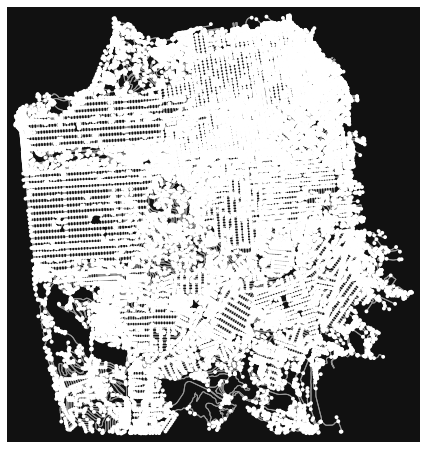

2022-02-01 18:29:40 Finished plotting the graph


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [19]:
ox.plot_graph(G)

In [55]:
# G = ox.distance.add_edge_lengths(G)
G = ox.utils_graph.add_edge_lengths(G)

2022-02-18 12:03:35 Added edge lengths to graph


In [56]:
tmp = relevant_blocks.to_crs('epsg:4326').centroid[84]
start = (tmp.y, tmp.x)
end = (lat,lng)
start_node = ox.get_nearest_node(G, start)
end_node = ox.get_nearest_node(G, end)

/var/folders/sm/3fwnfv0s4dz92rkrtnq8vcbr0000gn/T/ipykernel_18754/970351499.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tmp = relevant_blocks.to_crs('epsg:4326').centroid[84]


NameError: name 'lat' is not defined

In [ ]:
route = nx.shortest_path(G, start_node, end_node, weight='distance')

In [ ]:
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [57]:
def path_cost(G, path):
    return sum([G[path[i]][path[i+1]][0]['length'] for i in range(len(path)-1)])

# path_cost(G, route)

In [61]:
def get_close_blocks(G, end_node, relevant_blocks):
    close_blocks = []
    for idx, row in relevant_blocks.iterrows():
#         start = (row['lat'], row['lon'])
#         print(start)
        start_node = ox.get_nearest_node(G, (float(row['block_lon']), float(row['block_lat'])))
        route = nx.shortest_path(G, start_node, end_node, weight='distance')
#         print(route, path_cost(G, route))
        if path_cost(G, route) < 1609:
            close_blocks.append(row['BlockGroup'])
    return [int(x) for x in close_blocks]

In [62]:
walk_distance_blocks = {}
for idx, row in relevant_schools.tail(22).iterrows():
    school_relevant_blocks = get_relevant_blocks(streets, buffered_sch, buffered_census, row.school_id)
    end_node = ox.get_nearest_node(G, (float(row['lon']), float(row['lat'])))
    close_blocks = get_close_blocks(G, end_node, school_relevant_blocks)
    walk_distance_blocks[row['school_id']] = close_blocks

2022-02-18 12:04:29 Found nearest node (65444894) to point (-122.439627, 37.787702)
2022-02-18 12:04:29 Found nearest node (65444894) to point (-122.44930143117712, 37.790604452354515)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.44894170712483, 37.7888371271144)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.45032358158713, 37.787285246253425)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.45503834844021, 37.78910628665205)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.45730176977219, 37.787276539867264)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.43748705640868, 37.79027010039751)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.44227076080409, 37.78876148101208)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.44261960985392, 37.79054440908065)
2022-02-18 12:04:30 Found nearest node (65444894) to point (-122.4328679869692, 37.791848188610984)
2022-02-18 12:

2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41742890967097, 37.75310415314495)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41707765780647, 37.7494627583927)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41251624147279, 37.762257558409374)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41468914193426, 37.758896974673185)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41438215023301, 37.75569902909856)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41447057177767, 37.75274567020492)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41278255449298, 37.750446086234575)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41488692481545, 37.74955277562049)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.41482443702948, 37.74743135843958)
2022-02-18 12:04:34 Found nearest node (65444894) to point (-122.476815, 37.763294)
2022-02-18 12:

2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41742890967097, 37.75310415314495)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41707765780647, 37.7494627583927)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41251624147279, 37.762257558409374)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41468914193426, 37.758896974673185)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41438215023301, 37.75569902909856)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41447057177767, 37.75274567020492)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41278255449298, 37.750446086234575)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41488692481545, 37.74955277562049)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.41482443702948, 37.74743135843958)
2022-02-18 12:04:38 Found nearest node (65444894) to point (-122.436455, 37.766972)
2022-02-18 12:

2022-02-18 12:04:42 Found nearest node (65444894) to point (-122.49038363630709, 37.748949266572744)
2022-02-18 12:04:42 Found nearest node (65444894) to point (-122.49077390803016, 37.75454629151057)
2022-02-18 12:04:42 Found nearest node (65444894) to point (-122.49064686619667, 37.75267877076833)
2022-02-18 12:04:42 Found nearest node (65444894) to point (-122.49051190423216, 37.75081334812518)
2022-02-18 12:04:42 Found nearest node (65444894) to point (-122.49880603085188, 37.7541856874311)
2022-02-18 12:04:43 Found nearest node (65444894) to point (-122.49921229962139, 37.75185819544349)
2022-02-18 12:04:43 Found nearest node (65444894) to point (-122.50521707919917, 37.75203861594)
2022-02-18 12:04:43 Found nearest node (65444894) to point (-122.50540815472958, 37.75390241742474)
2022-02-18 12:04:43 Found nearest node (65444894) to point (-122.433619, 37.79266)
2022-02-18 12:04:43 Found nearest node (65444894) to point (-122.42501638752165, 37.79509775689516)
2022-02-18 12:04:43 

In [54]:
school_relevant_blocks = get_relevant_blocks(streets, buffered_sch, buffered_census, 750)
sch = relevant_schools.loc[relevant_schools.school_id==750].reset_index()
end_node = ox.distance.nearest_nodes(G, float(sch['lon'][0]), float(sch['lat'][0]))
close_blocks = get_close_blocks(G, end_node, school_relevant_blocks)
school_relevant_streets = get_relevant_streets(streets, buffered_sch, 750)

2022-02-01 18:47:36 Created nodes GeoDataFrame from graph
2022-02-01 18:47:36 Created nodes GeoDataFrame from graph
2022-02-01 18:47:36 Created nodes GeoDataFrame from graph
2022-02-01 18:47:36 Created nodes GeoDataFrame from graph
2022-02-01 18:47:36 Created nodes GeoDataFrame from graph
2022-02-01 18:47:37 Created nodes GeoDataFrame from graph
2022-02-01 18:47:37 Created nodes GeoDataFrame from graph
2022-02-01 18:47:37 Created nodes GeoDataFrame from graph
2022-02-01 18:47:37 Created nodes GeoDataFrame from graph
2022-02-01 18:47:37 Created nodes GeoDataFrame from graph
2022-02-01 18:47:37 Created nodes GeoDataFrame from graph
2022-02-01 18:47:38 Created nodes GeoDataFrame from graph
2022-02-01 18:47:38 Created nodes GeoDataFrame from graph
2022-02-01 18:47:38 Created nodes GeoDataFrame from graph
2022-02-01 18:47:38 Created nodes GeoDataFrame from graph
2022-02-01 18:47:38 Created nodes GeoDataFrame from graph
2022-02-01 18:47:39 Created nodes GeoDataFrame from graph
2022-02-01 18:

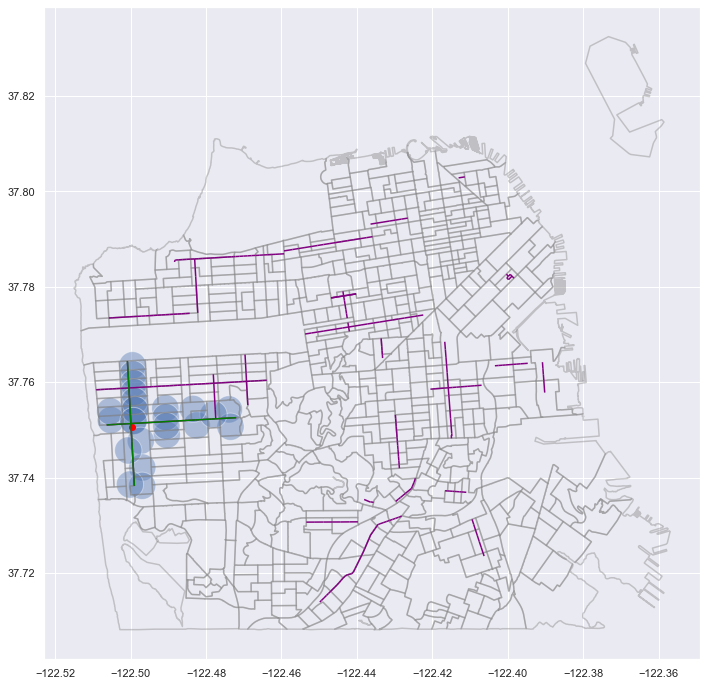

In [55]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.to_crs('epsg:4326').plot(ax=ax, color='gray', alpha=0.4)
school_relevant_blocks.to_crs('epsg:4326').plot(ax=ax,alpha=.4)
slow_streets.to_crs('epsg:4326').plot(ax=ax, color='purple')
school_relevant_streets.to_crs('epsg:4326').plot(ax=ax, color='green')
plt.scatter(float(sch['lon'][0]), float(sch['lat'][0]), color='red')
plt.show()

525


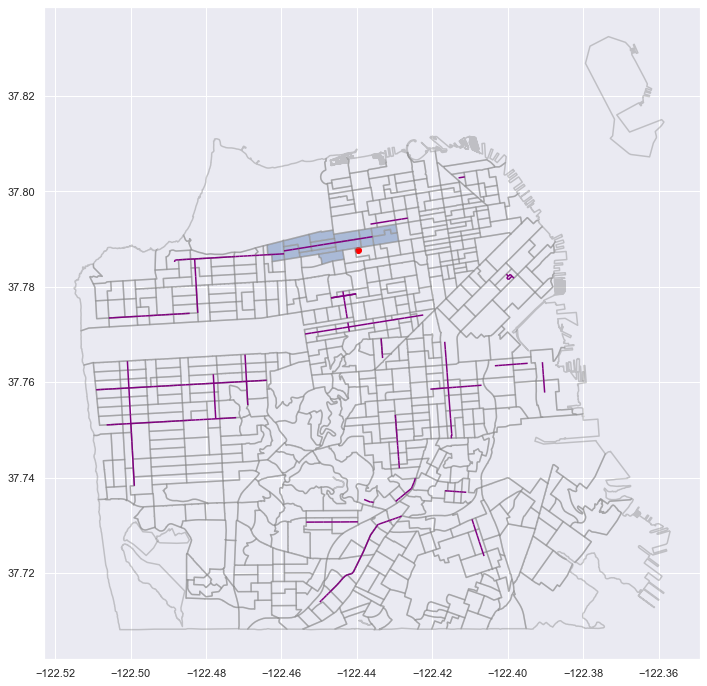

537


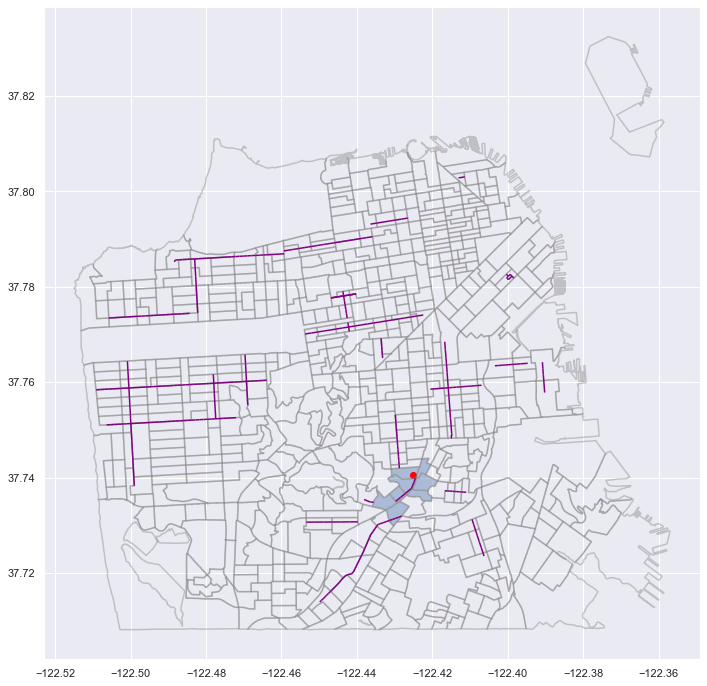

544


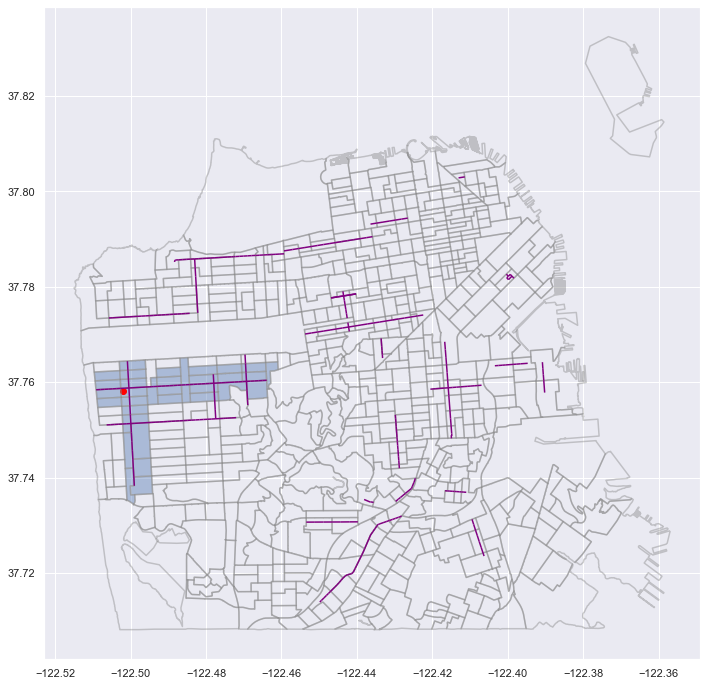

569


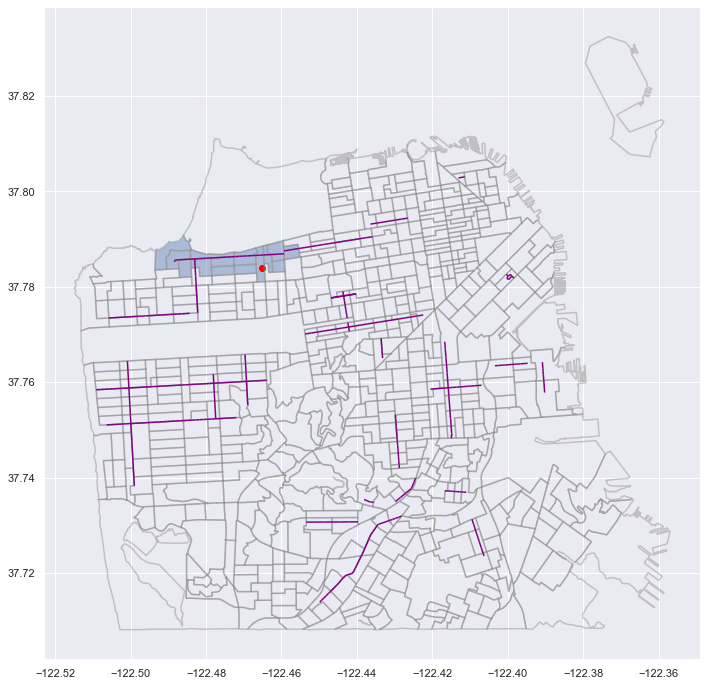

575


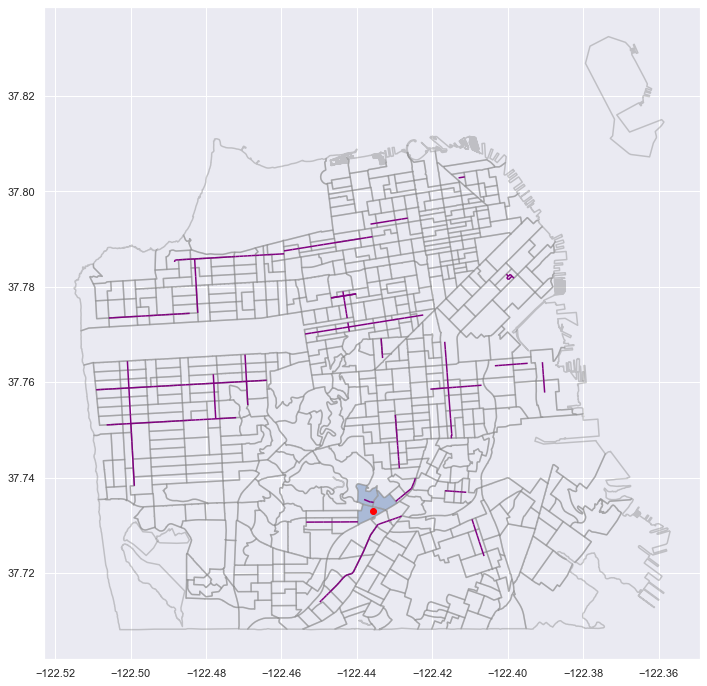

603


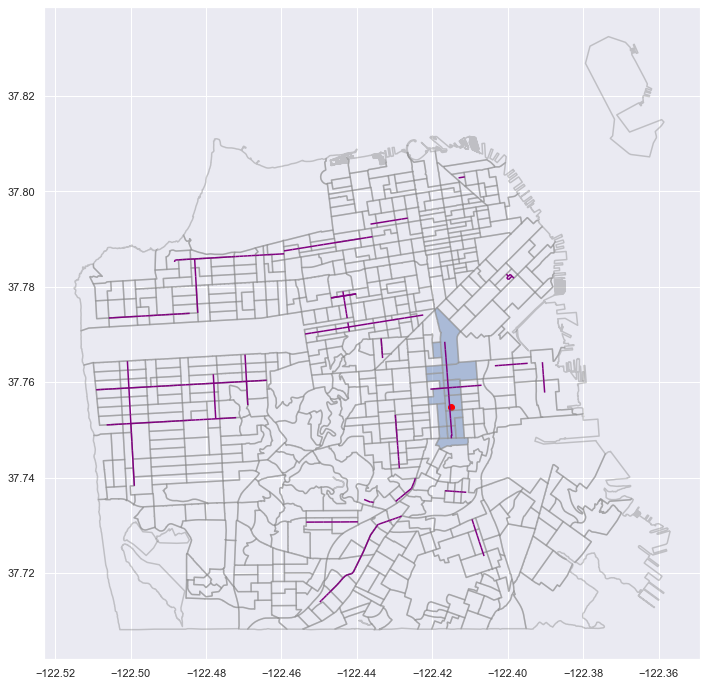

644


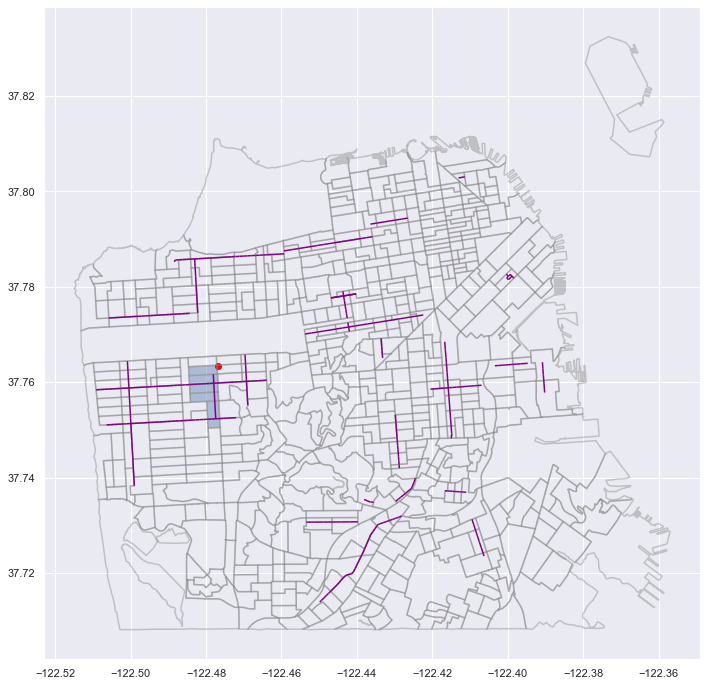

650


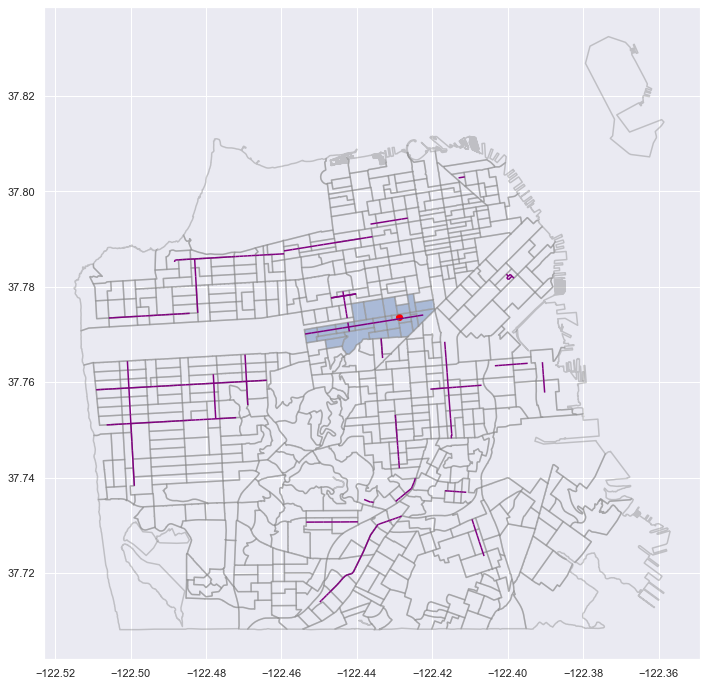

676


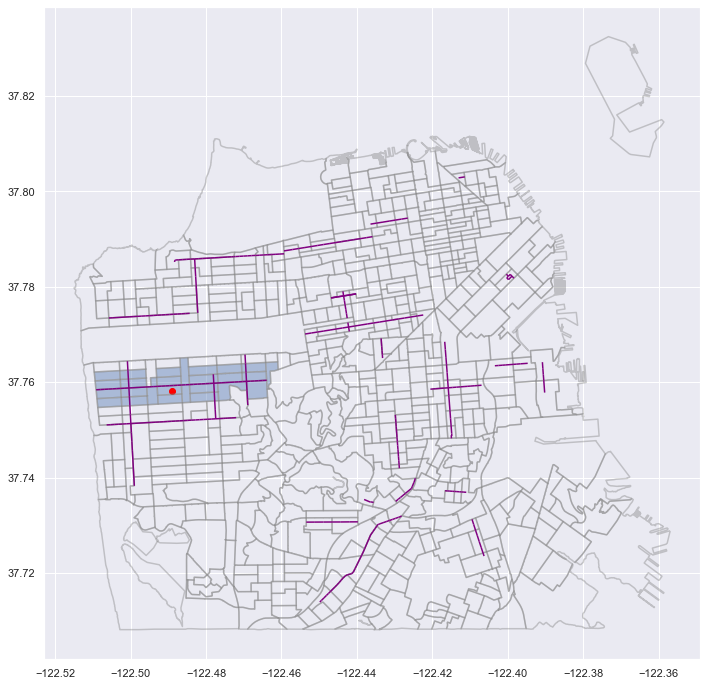

680


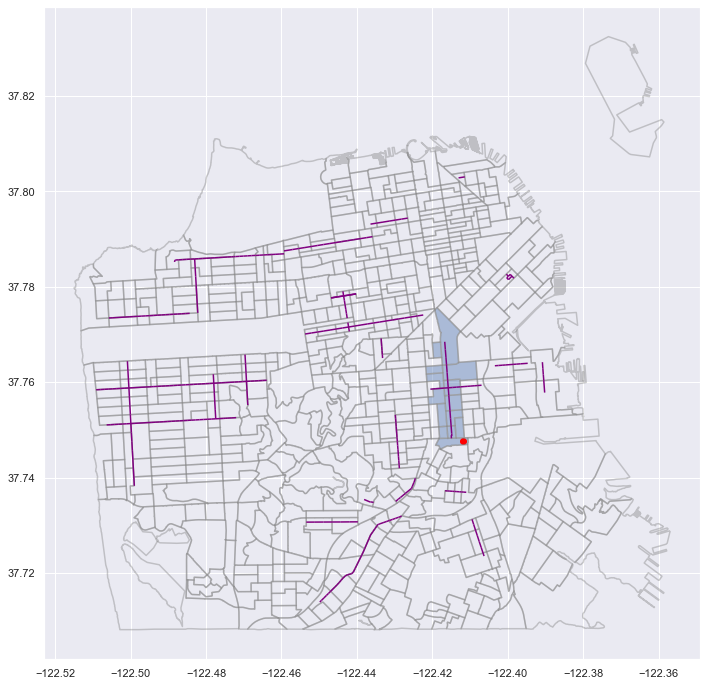

714


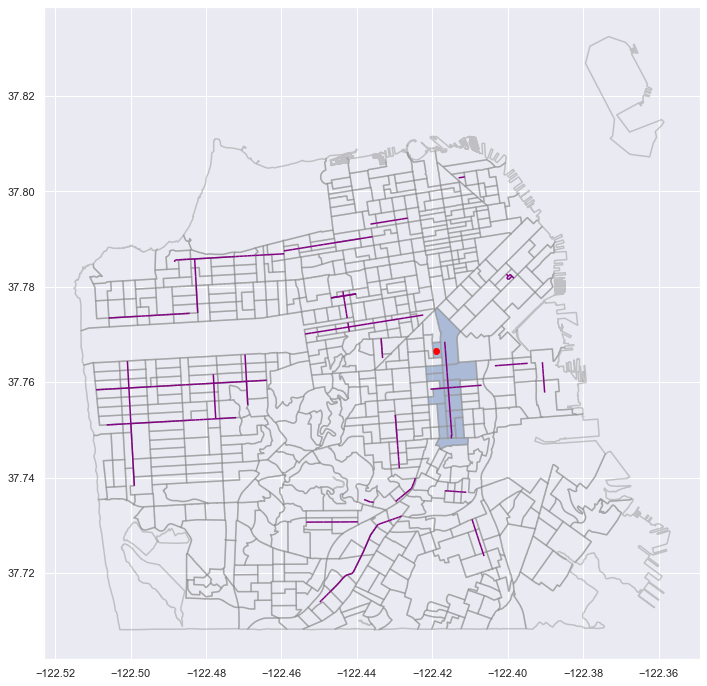

718


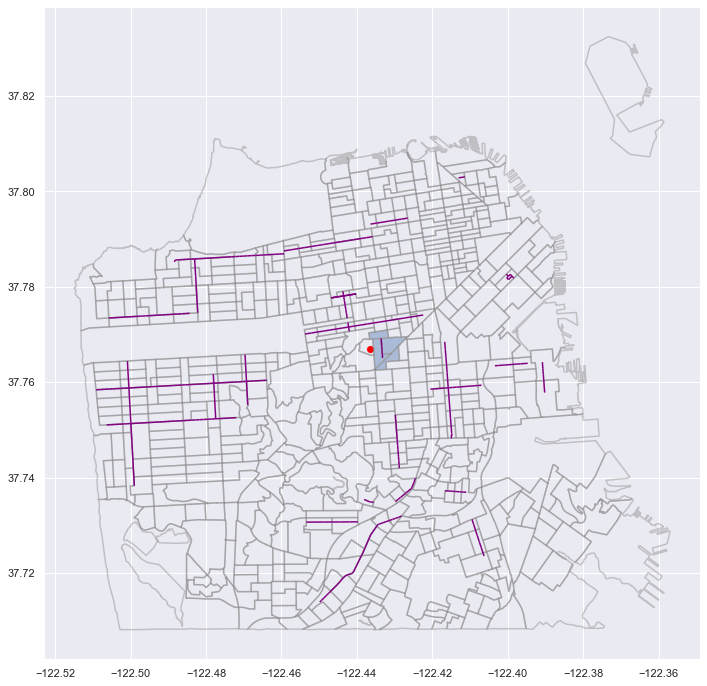

723


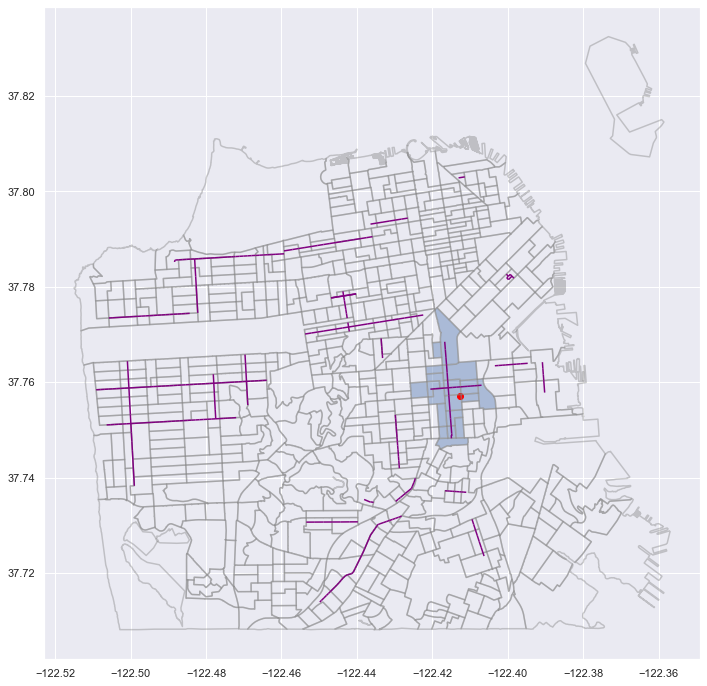

724


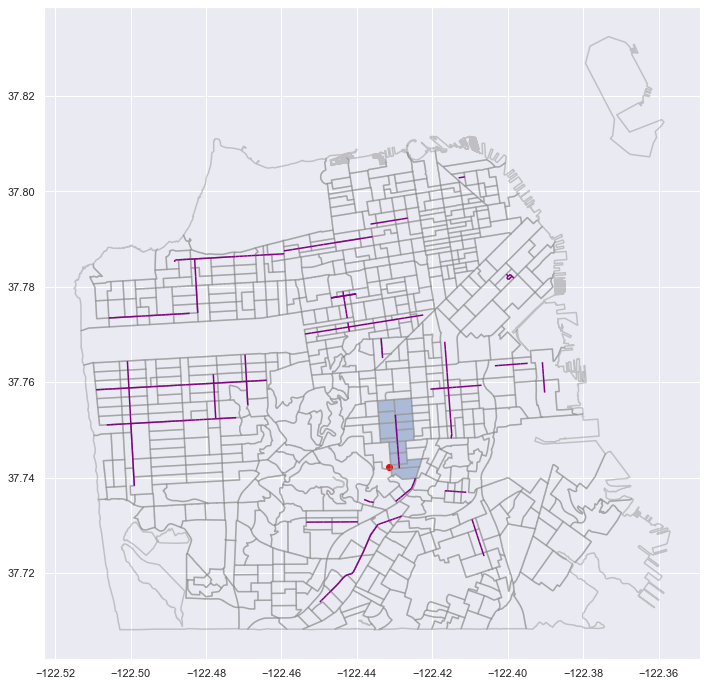

750


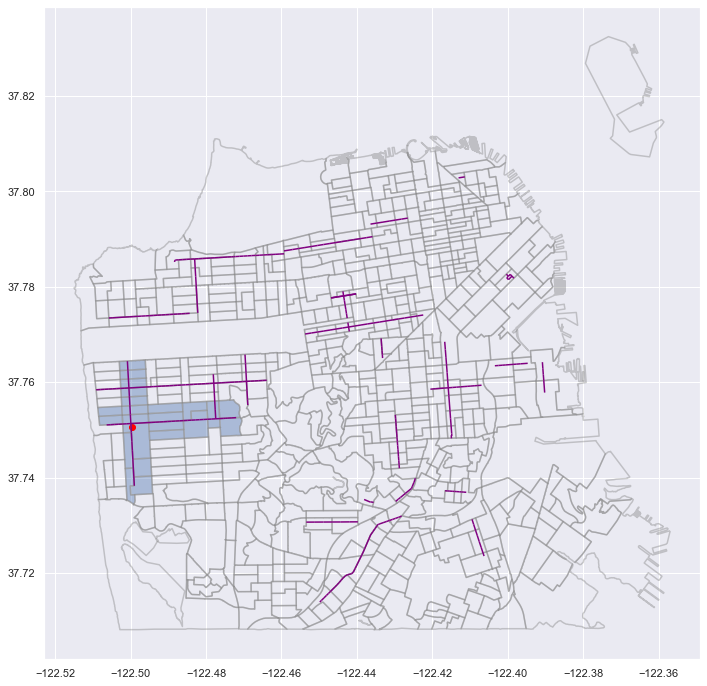

760


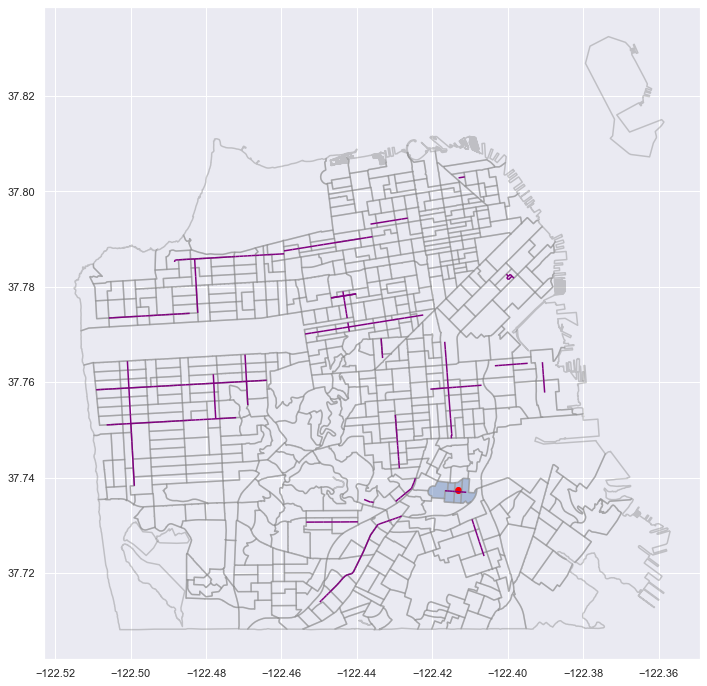

782


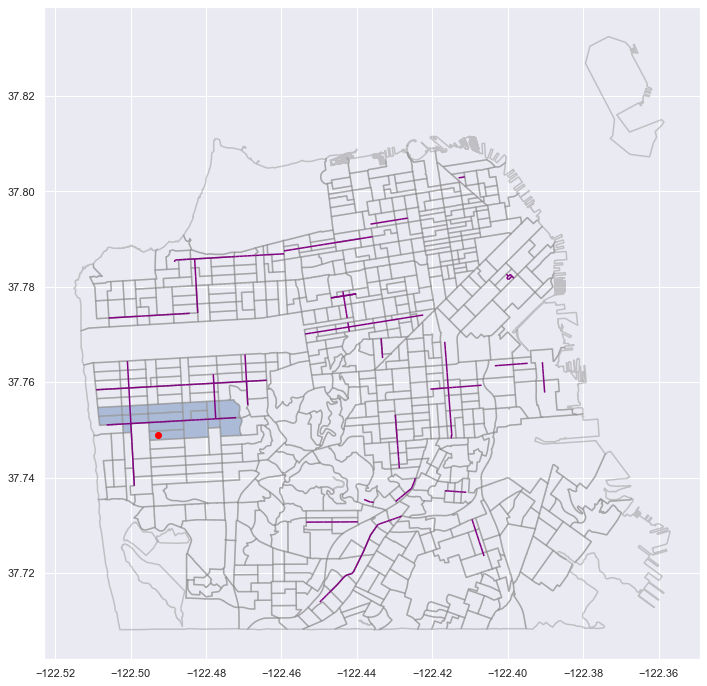

814


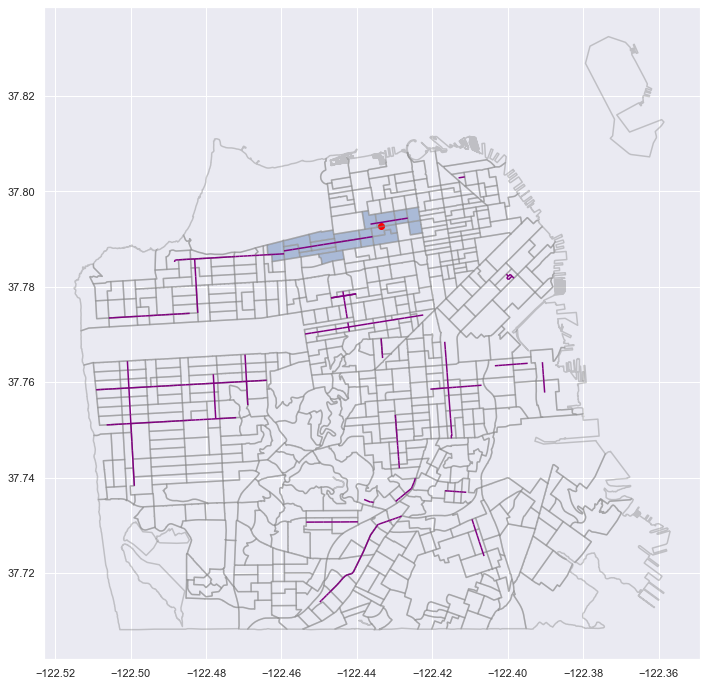

816


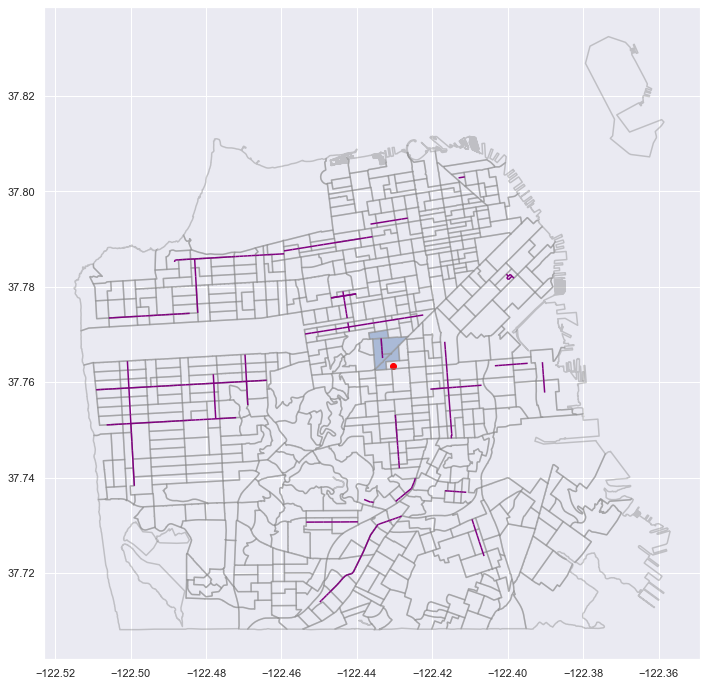

842


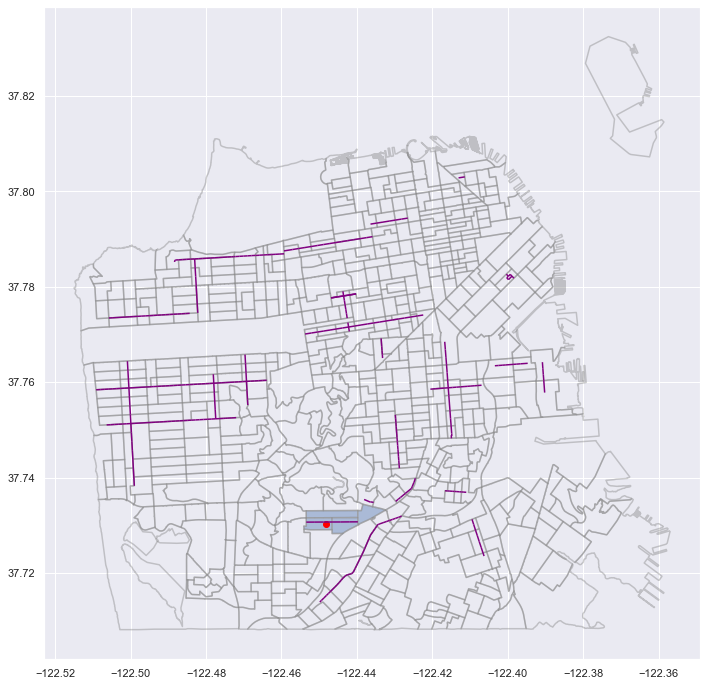

848


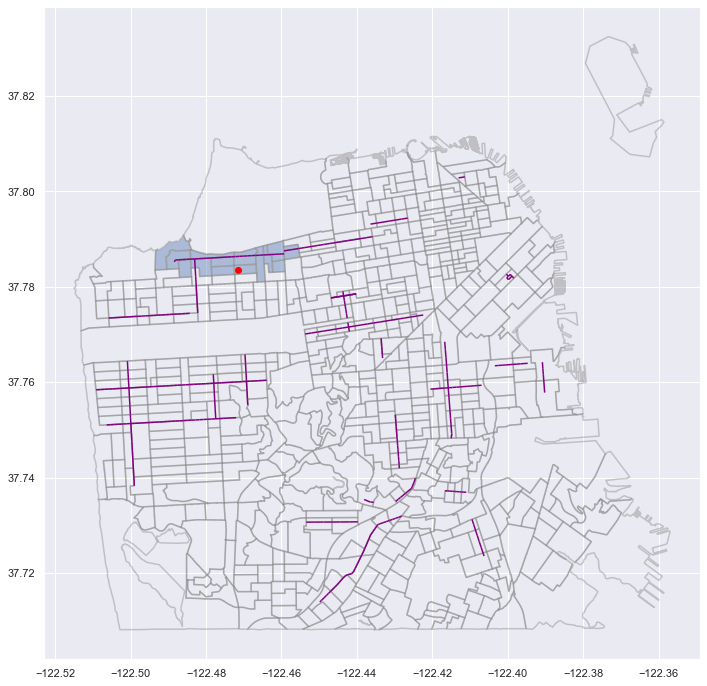

862


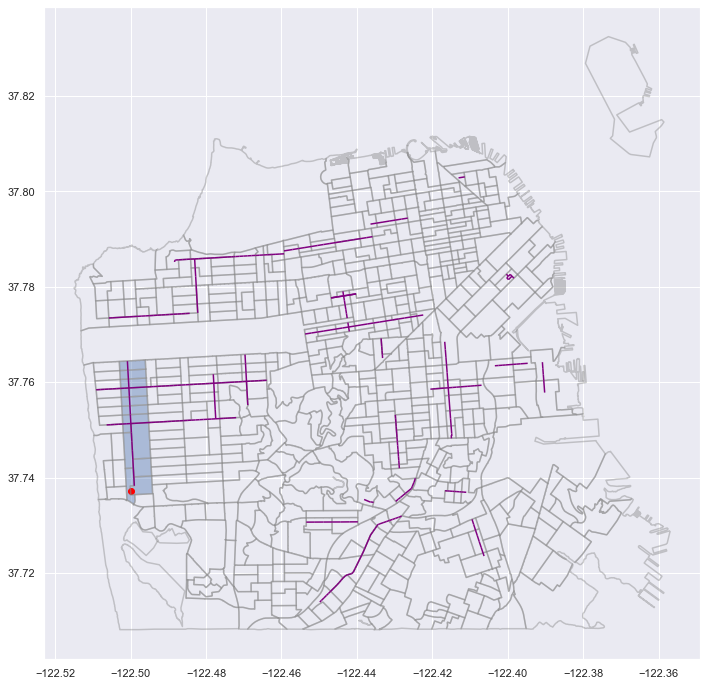

In [63]:
for sch, close_blocks in walk_distance_blocks.items():
    print(sch)
    plt.figure(figsize=(12,12))
    ax = plt.gca()
    census.boundary.to_crs('epsg:4326').plot(ax=ax, color='gray', alpha=0.4)
    school = relevant_schools.loc[relevant_schools.school_id == sch]
    census.loc[census['BlockGroup'].isin([int(x) for x in close_blocks])].to_crs('epsg:4326').plot(ax=ax,alpha=.4)
    slow_streets.to_crs('epsg:4326').plot(ax=ax, color='purple')
    plt.scatter(school['lon'],school['lat'], color='red')
    plt.show()

In [246]:
len(relevant_schools)

27

In [62]:
import yaml
with open("/Users/katherinementzer/Dropbox/SFUSD/slow_street_walk_zones.yaml", "r") as f:
    old = yaml.safe_load(f)
    
full = {**old, **walk_distance_blocks}
with open('/Users/katherinementzer/Dropbox/SFUSD/slow_street_walk_zones.yaml', 'w') as outfile:
    yaml.dump(full, outfile)

In [10]:
census['block_lat'] = census.centroid.to_crs('epsg:4326').y
census['block_lon'] = census.centroid.to_crs('epsg:4326').x

In [16]:
census_centroids = census.copy()
census_centroids.geometry = [Point(xy) for xy in zip(census.centroid.x, census.centroid.y)]

In [22]:
buffered_sch.columns

Index(['school_id', 'school_name', 'school_name_long', 'lat', 'lon', 'zip',
       'category', 'grades', 'cap_lb', 'eng_scores_1819', 'math_scores_1819',
       'greatschools_rating', 'ela_color', 'math_color', 'chronic_color',
       'suspension_color', 'attendance_area', 'Block', 'BlockGroup', 'Tract',
       'MetStandards', 'AvgColorIndex', 'geometry'],
      dtype='object')

<AxesSubplot:>

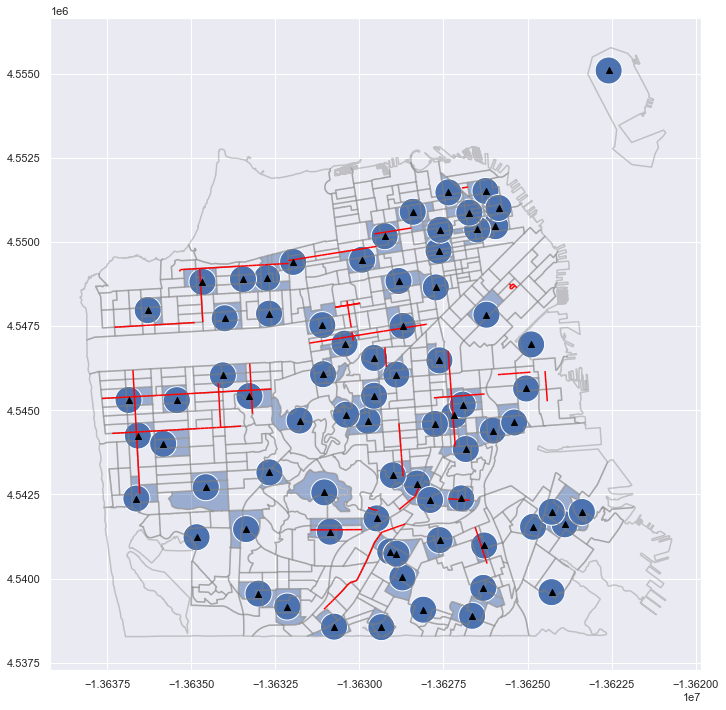

In [23]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
census.loc[census.BlockGroup.isin(census_centroids.sjoin(buffered_sch.drop(columns=['BlockGroup'])).BlockGroup)].plot(ax=ax, alpha=.5)
sc_df.plot(ax=ax, c='black', marker='^', zorder=50)
buffered_sch.plot(ax=ax)
slow_streets.plot(ax=ax, color='red')

In [28]:
normal_walk_zone = census_centroids.sjoin(buffered_sch.drop(columns=['BlockGroup']))[['school_id', 'BlockGroup']].groupby('school_id').agg(lambda x: list(x))

In [32]:
normal_walk_dict = dict(zip(normal_walk_zone.index, normal_walk_zone.BlockGroup))

In [76]:
import yaml

# with open("/Users/katherinementzer/Dropbox/SFUSD/slow_street_walk_zones.yaml", "r") as f:
#     old = yaml.safe_load(f)

new = {}
for sch, blocks in walk_distance_blocks.items():
    if sch in normal_walk_dict:
        new[sch] = blocks + [int(x) for x in normal_walk_dict[sch]]
    else:
        new[sch] = blocks
for sch, blocks in normal_walk_dict.items():
    if sch not in new:
        new[sch] = [int(x) for x in blocks]
        
with open('/Users/katherinementzer/Dropbox/SFUSD/slow_street_walk_zones.yaml', 'w') as outfile:
    yaml.dump(new, outfile)

In [37]:
with open("/Users/katherinementzer/Dropbox/SFUSD/slow_street_walk_zones.yaml", "r") as f:
    old = yaml.safe_load(f)

In [77]:
new

{525: [60750133001,
  60750133002,
  60750133003,
  60750133004,
  60750133005,
  60750134001,
  60750134002,
  60750134003,
  60750135001,
  60750135002,
  60750154001,
  60750401001,
  60750134002,
  60750153001,
  60750153002],
 537: [60750218001,
  60750218002,
  60750218003,
  60750218004,
  60750253003,
  60750254011,
  60750254013,
  60750255001,
  60750215003,
  60750218001,
  60750218002,
  60750253003,
  60750254011],
 544: [60750301014,
  60750302012,
  60750302013,
  60750302022,
  60750302023,
  60750303011,
  60750303012,
  60750326012,
  60750326013,
  60750326021,
  60750326022,
  60750326023,
  60750327002,
  60750327003,
  60750327004,
  60750327005,
  60750327006,
  60750351002,
  60750351003,
  60750351004,
  60750351005,
  60750352013,
  60750352014,
  60750352022,
  60750352023,
  60750351001,
  60750351002,
  60750351003,
  60750351004,
  60750351005,
  60750351006,
  60750351007,
  60750353001,
  60750353002,
  60750353003,
  60750353005,
  60750353006,
  607503